# Importing libraries

In [1]:
# Data processing
# ==============================================================================
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from itertools import product, chain
import math
import holidays
from calendar import day_abbr

# Plots
# ==============================================================================
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Modelling and Forecasting
# ==============================================================================
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, FunctionTransformer
)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    train_test_split, KFold, GridSearchCV, ParameterGrid,
)
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, DMatrix, plot_importance
from xgboost import cv as xgb_cv

# Configuration warnings
# ==============================================================================
import warnings

# Generating Data file
# Note: Please do not run this section, it'll take alot of time and computer power

In [42]:
# The required data file has already been prepared for use and saved as 'Consumption.xlsx'.
# Skip this part and move directly to next section 'Loading the Data'.

In [ ]:
root_2015 = ET.parse('Data/2015.xml').getroot()
root_2016 = ET.parse('Data/2016.xml').getroot()
root_2017 = ET.parse('Data/2017.xml').getroot()
root_2018 = ET.parse('Data/2018.xml').getroot()
root_2019 = ET.parse('Data/2019.xml').getroot()
root_2020 = ET.parse('Data/2020.xml').getroot()
root_2021 = ET.parse('Data/2021.xml').getroot()
root_2022 = ET.parse('Data/2022.xml').getroot()
root_2023 = ET.parse('Data/2023.xml').getroot()

In [ ]:
df_2015= pd.DataFrame(columns = ['quantity'])
for i in range(365):
    for j in range(96):
        df_2015=df_2015.append({'quantity': root_2015[i+10][6][j+2][1].text}, ignore_index=True)

df_2016= pd.DataFrame(columns = ['quantity'])
for i in range(366):
    for j in range(96):
        df_2016=df_2016.append({'quantity': root_2016[i+10][6][j+2][1].text}, ignore_index=True)

df_2017= pd.DataFrame(columns = ['quantity'])
for i in range(365):
    for j in range(96):
        df_2017=df_2017.append({'quantity': root_2017[i+10][6][j+2][1].text}, ignore_index=True)

df_2018= pd.DataFrame(columns = ['quantity'])
for i in range(365):
    for j in range(96):
        df_2018=df_2018.append({'quantity': root_2018[i+10][6][j+2][1].text}, ignore_index=True)

df_2019= pd.DataFrame(columns = ['quantity'])
for i in range(365):
    for j in range(96):
        df_2019=df_2019.append({'quantity': root_2019[i+10][6][j+2][1].text}, ignore_index=True)

df_2020= pd.DataFrame(columns = ['quantity'])
for i in range(366):
    for j in range(96):
        df_2020=df_2020.append({'quantity': root_2020[i+10][6][j+2][1].text}, ignore_index=True)

df_2021= pd.DataFrame(columns = ['quantity'])
for i in range(365):
    for j in range(96):
        df_2021=df_2021.append({'quantity': root_2021[i+10][6][j+2][1].text}, ignore_index=True)

df_2022= pd.DataFrame(columns = ['quantity'])
for i in range(365):
    for j in range(96):
        df_2022=df_2022.append({'quantity': root_2022[i+10][6][j+2][1].text}, ignore_index=True)

df_2023= pd.DataFrame(columns = ['quantity'])
for i in range(365):
    for j in range(96):
        df_2023=df_2023.append({'quantity': root_2023[i+10][6][j+2][1].text}, ignore_index=True)

In [ ]:
df=df_2015
df = df.append([df_2016, df_2017,df_2018,df_2019, df_2020,df_2021,df_2022, df_2023])
print(df.shape)
df['quantity']=df['quantity'].astype(float)
df.to_excel('Consumption.xlsx')

# Loading the data

In [2]:
start_date = pd.Timestamp("2015-01-01 00:00:00", tz="utc")
end_date = pd.Timestamp("2023-12-31 23:00:00", tz="utc")

In [3]:
de_consumption = pd.read_excel('Consumption.xlsx')
de_consumption['start'] = pd.date_range('2015-01-01 00:00', '2023-12-31 23:45:00', freq='15min',tz='utc')
de_consumption = de_consumption.drop(columns="Unnamed: 0").set_index("start")
de_consumption.index.name = "time"
de_consumption = de_consumption.groupby(pd.Grouper(freq="h")).mean()
de_consumption = de_consumption.loc[
    (de_consumption.index >= start_date) & (de_consumption.index <= end_date), :
]
de_consumption.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78888 entries, 2015-01-01 00:00:00+00:00 to 2023-12-31 23:00:00+00:00
Freq: H
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   quantity  78888 non-null  float64
dtypes: float64(1)
memory usage: 1.2 MB


In [4]:
de_consumption.rename(columns={"quantity":"Consumption"},inplace=True)

In [5]:
de_consumption.describe()

,Consumption
count,78888.000000
mean,56341.871701
std,10000.834364
min,30909.000000
25%,48116.437500
50%,56025.000000
75%,64671.562500
max,81077.500000


In [6]:
de_consumption.tail()

,Consumption
time,
2023-12-31 19:00:00+00:00,45698.50
2023-12-31 20:00:00+00:00,43818.00
2023-12-31 21:00:00+00:00,42893.50
2023-12-31 22:00:00+00:00,41471.75
2023-12-31 23:00:00+00:00,39068.50


In [7]:
def train_test(df, split_time):
    df_train = df.loc[df.index < split_time]
    df_test = df.loc[df.index >= split_time]
    return df_train, df_test

df_train, df_test = train_test(
    de_consumption, pd.Timestamp("2023-01-01", tz="utc")
)

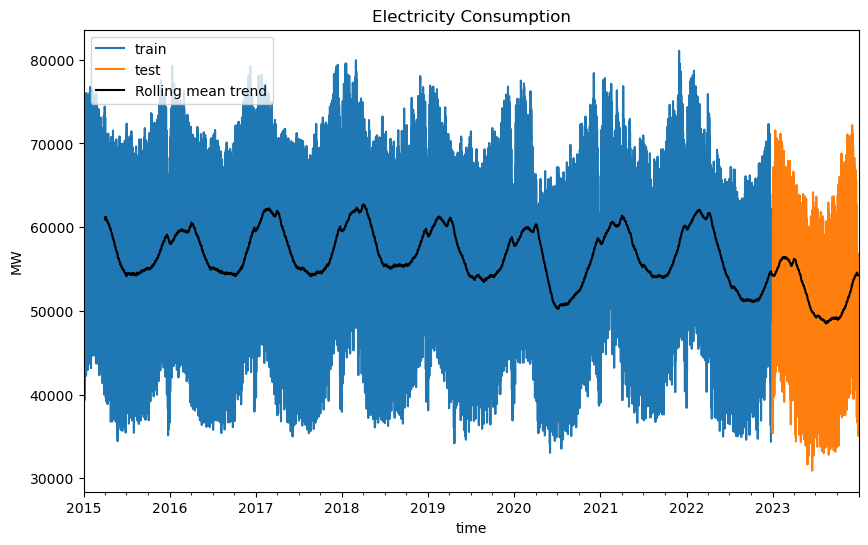

In [8]:
rolling_mean = de_consumption.rolling(window=24*30*3).mean()
ax = df_train["Consumption"].plot(figsize=(10, 6), color="tab:blue",label="train")
_ = df_test["Consumption"].plot(ax=ax, color="tab:orange", ylabel="MW",label="test")
_ = rolling_mean["Consumption"].plot(ax=ax, color="black", ylabel="MW",label="Rolling mean trend")
ax.set_title("Electricity Consumption")
ax.legend(loc="upper left")
plt.savefig("Electricity_consumption.png", bbox_inches="tight")
#fig.savefig('Consumption.png', dpi=fig.dpi)

# Features plot for display

In [9]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['hour_sin'] = np.sin(df['hour'] / 23 * 2 * np.pi)
    df['hour_cos'] = np.cos(df['hour'] / 23 * 2 * np.pi)
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df_features_plot = create_features(df_train)

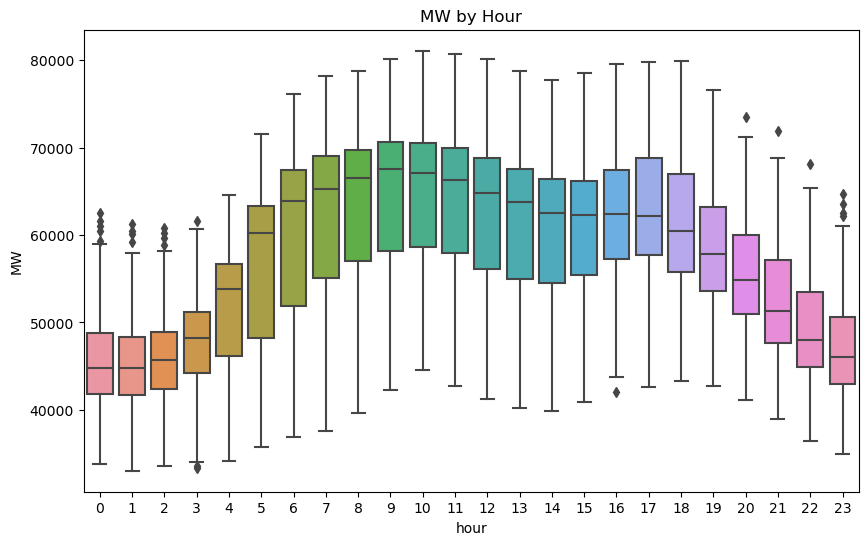

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df_features_plot, x='hour', y='Consumption')
ax.set(ylabel='MW')
ax.set_title('MW by Hour')
plt.show()
fig.savefig('Hourly.png', dpi=fig.dpi, bbox_inches="tight")

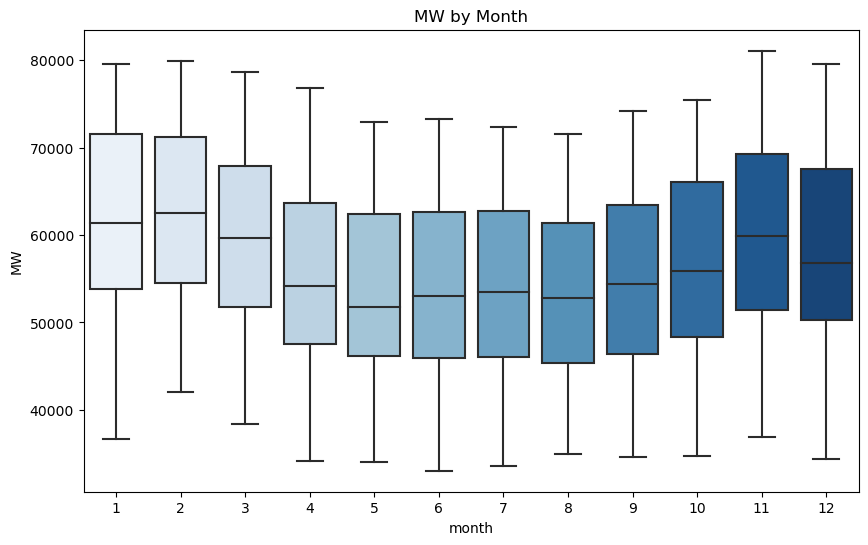

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df_features_plot, x='month', y='Consumption', palette='Blues')
ax.set(ylabel='MW')
ax.set_title('MW by Month')
plt.show()
fig.savefig('Monthly.png', dpi=fig.dpi, bbox_inches="tight")

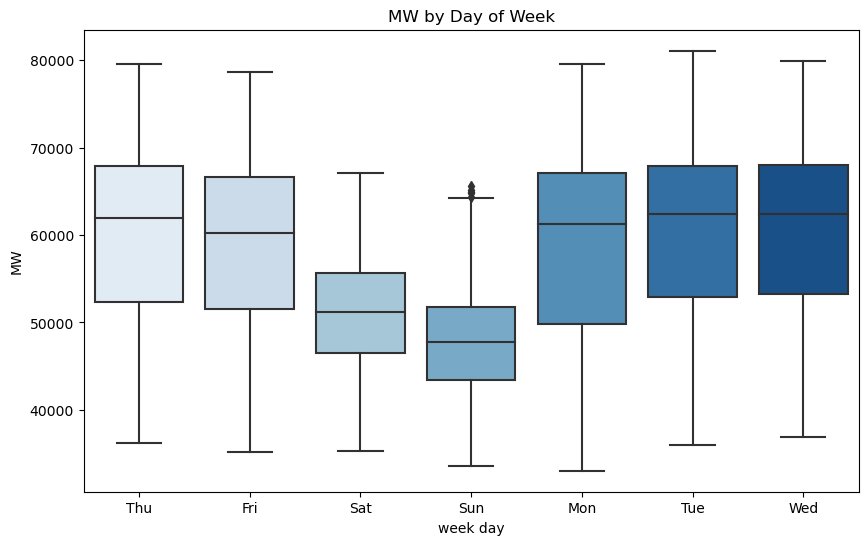

In [12]:
df_features_plot['dayofweek'] = df_features_plot['dayofweek'].apply(lambda w:day_abbr[w])
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df_features_plot, x='dayofweek', y='Consumption', palette='Blues')
ax.set(ylabel='MW',xlabel='week day')
ax.set_title('MW by Day of Week')
plt.show()
fig.savefig('Daily.png', dpi=fig.dpi, bbox_inches="tight")

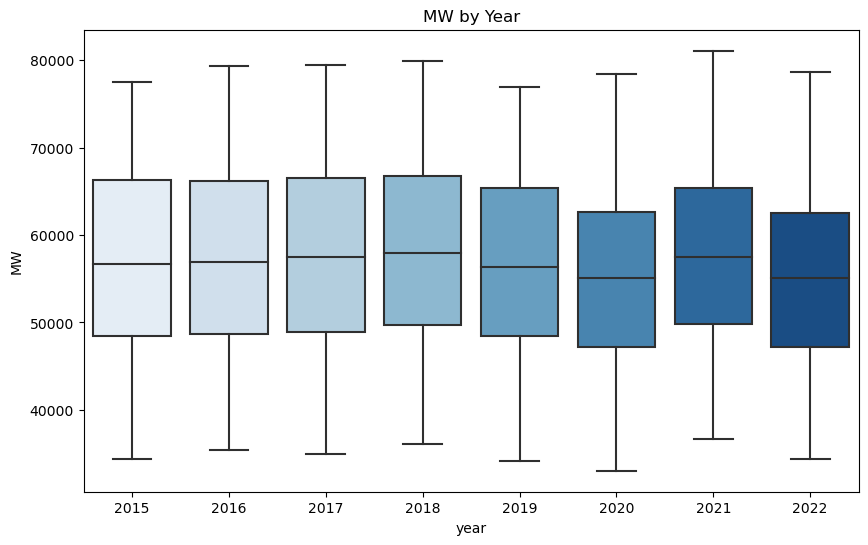

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df_features_plot, x='year', y='Consumption', palette='Blues')
ax.set(ylabel='MW')
ax.set_title('MW by Year')
plt.show()
fig.savefig('Yearly.png', dpi=fig.dpi, bbox_inches="tight")

# Features for modelling

In [14]:
def time_features(df):
    cet_index = df.index.tz_convert("CET")
    df["month"] = cet_index.month
    df["weekday"] = cet_index.weekday
    df['hour_sin'] = np.sin(cet_index.hour / 23 * 2 * np.pi)
    df['hour_cos'] = np.cos(cet_index.hour / 23 * 2 * np.pi)
    return df

def holiday_features(df):
    de_holidays = holidays.Germany()
    cet_dates = pd.Series(df.index.tz_convert("CET"), index=df.index)
    df["holiday"] = cet_dates.apply(lambda d: d in de_holidays)
    df["holiday"] = df["holiday"].astype(int)
    return df

def lag_features(df, col="Consumption"):
    for n_hours in list(range(24, 49)) + list(range(167, 170)):
        shifted_col = df[col].shift(n_hours, "h")
        shifted_col = shifted_col.loc[df.index.min(): df.index.max()]
        label = f"{col}_lag_{n_hours}"
        df[label] = np.nan
        df.loc[shifted_col.index, label] = shifted_col
    return df

def all_features(df, target_col="Consumption"):
    df = df.copy()
    df = time_features(df)
    df = holiday_features(df)
    df = lag_features(df, col=target_col)
    return df


In [15]:
df_train = all_features(df_train).dropna()
df_test = all_features(df_test).dropna()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69959 entries, 2015-01-08 01:00:00+00:00 to 2022-12-31 23:00:00+00:00
Freq: H
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Consumption          69959 non-null  float64
 1   month                69959 non-null  int64  
 2   weekday              69959 non-null  int64  
 3   hour_sin             69959 non-null  float64
 4   hour_cos             69959 non-null  float64
 5   holiday              69959 non-null  int32  
 6   Consumption_lag_24   69959 non-null  float64
 7   Consumption_lag_25   69959 non-null  float64
 8   Consumption_lag_26   69959 non-null  float64
 9   Consumption_lag_27   69959 non-null  float64
 10  Consumption_lag_28   69959 non-null  float64
 11  Consumption_lag_29   69959 non-null  float64
 12  Consumption_lag_30   69959 non-null  float64
 13  Consumption_lag_31   69959 non-null  float64
 14  Consumption_lag_32   69959 non-

In [16]:
target_col = "Consumption"
X_train = df_train.drop(columns=target_col)
y_train = df_train.loc[:, target_col]
X_test = df_test.drop(columns=target_col)
y_test = df_test.loc[:, target_col]

# Data preparation

In [17]:
def fit_preparation_pipeline(df):
    cat_features = ["month", "weekday", "hour_sin","hour_cos"]  # categorical features
    bool_features = ["holiday"]  # boolean features
    num_features = [c for c in df.columns
                    if c.startswith("Consumption_lag")]  # numerical features
    preparation_pipeline = ColumnTransformer([
        ("cat", OneHotEncoder(), cat_features),
        ("bool", FunctionTransformer(), bool_features),  # identity
        ("num", StandardScaler(), num_features),
    ])
    preparation_pipeline = preparation_pipeline.fit(df)
    
    feature_names = []
    one_hot_tf = preparation_pipeline.transformers_[0][1]
    for i, cat_feature in enumerate(cat_features):
        categories = one_hot_tf.categories_[i]
        cat_names = [f"{cat_feature}_{c}" for c in categories]
        feature_names += cat_names
    feature_names += (bool_features + num_features)
    
    return feature_names, preparation_pipeline

In [18]:
feature_names, preparation_pipeline = fit_preparation_pipeline(X_train)

X_train_prep = preparation_pipeline.transform(X_train)
X_train_prep = pd.DataFrame(X_train_prep, columns=feature_names, index=df_train.index)
X_test_prep = preparation_pipeline.transform(X_test)
X_test_prep = pd.DataFrame(X_test_prep, columns=feature_names, index=df_test.index)

X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69959 entries, 2015-01-08 01:00:00+00:00 to 2022-12-31 23:00:00+00:00
Freq: H
Data columns (total 94 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   month_1                           69959 non-null  float64
 1   month_2                           69959 non-null  float64
 2   month_3                           69959 non-null  float64
 3   month_4                           69959 non-null  float64
 4   month_5                           69959 non-null  float64
 5   month_6                           69959 non-null  float64
 6   month_7                           69959 non-null  float64
 7   month_8                           69959 non-null  float64
 8   month_9                           69959 non-null  float64
 9   month_10                          69959 non-null  float64
 10  month_11                          69959 non-null  float64
 11  month_12    

# Training models

In [19]:
lin_model = SGDRegressor(penalty="elasticnet", tol=10, random_state=42)
rf_model = RandomForestRegressor(
    n_estimators=100, criterion='squared_error', min_samples_leaf=0.001, random_state=42
)
xgb_model = XGBRegressor(n_estimators=1000)


# Plotting Learning Curves

In [20]:
def compute_learning_curves(model, X, y, curve_step, verbose=False):
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )
    n_train_obs = X_train.shape[0]
    n_iter = math.ceil(n_train_obs / curve_step)
    train_errors, val_errors, steps = [], [], []
    for i in range(n_iter):
        n_obs = (i+1) * curve_step
        n_obs = min(n_obs, n_train_obs)
        model.fit(X_train[:n_obs], y_train[:n_obs])
        y_train_predict = model.predict(X_train[:n_obs])
        y_val_predict = model.predict(X_val)
        train_mse = mean_squared_error(y_train[:n_obs], y_train_predict)
        val_mse = mean_squared_error(y_val, y_val_predict)
        train_errors.append(train_mse)
        val_errors.append(val_mse)
        steps.append(n_obs)
        if verbose:
            msg = "Iteration {0}/{1}: train_rmse={2:.2f}, val_rmse={3:.2f}".format(
                i+1, n_iter, np.sqrt(train_mse), np.sqrt(val_mse)
            )
            print(msg)
    return steps, train_errors, val_errors

def plot_learning_curves(steps, train_errors, val_errors, ax=None, title=""):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    train_rmse = np.sqrt(train_errors)
    val_rmse = np.sqrt(val_errors)
    ax.plot(steps, train_rmse, color="tab:blue",
            marker=".", label="training")
    ax.plot(steps, val_rmse, color="tab:orange",
            marker=".", label="validation")
    ylim = (0.8*np.median(train_rmse),
            1.5*np.median(val_rmse))
    ax.set_ylim(ylim)
    ax.set_xlabel("Number of observations")
    ax.set_ylabel("RMSE (MW)")
    ax.set_title(title)
    ax.legend()
    ax.grid()
    fig.savefig(str(title) +'_rmse.png', dpi=fig.dpi)
    

In [36]:
steps, train_mse, val_mse = compute_learning_curves(
    lin_model, X_train_prep, y_train, 500, verbose=True
)

Iteration 1/112: train_rmse=2661.17, val_rmse=22383.14
Iteration 2/112: train_rmse=2349.20, val_rmse=12893.94
Iteration 3/112: train_rmse=2189.78, val_rmse=9036.04
Iteration 4/112: train_rmse=2053.83, val_rmse=7074.89
Iteration 5/112: train_rmse=2345.72, val_rmse=7149.99
Iteration 6/112: train_rmse=2355.26, val_rmse=5935.17
Iteration 7/112: train_rmse=2452.23, val_rmse=4996.66
Iteration 8/112: train_rmse=2531.27, val_rmse=5148.04
Iteration 9/112: train_rmse=2455.38, val_rmse=4569.87
Iteration 10/112: train_rmse=2406.53, val_rmse=4320.35
Iteration 11/112: train_rmse=2348.92, val_rmse=4288.26
Iteration 12/112: train_rmse=2290.91, val_rmse=3946.54
Iteration 13/112: train_rmse=2316.05, val_rmse=3530.19
Iteration 14/112: train_rmse=2275.05, val_rmse=3514.17
Iteration 15/112: train_rmse=2257.90, val_rmse=3134.57
Iteration 16/112: train_rmse=2237.29, val_rmse=2833.24
Iteration 17/112: train_rmse=2426.99, val_rmse=2749.72
Iteration 18/112: train_rmse=2539.28, val_rmse=2790.13
Iteration 19/112:

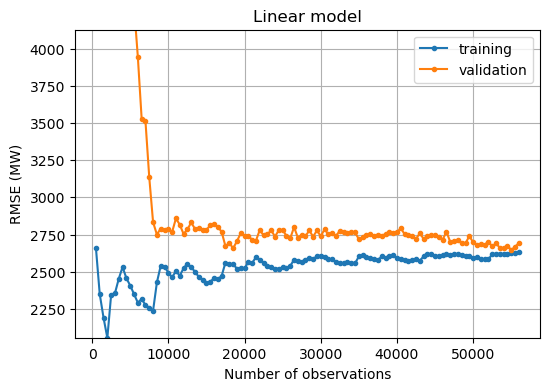

In [37]:
plot_learning_curves(steps, train_mse, val_mse, title="Linear model")

In [38]:
rf_steps, rf_train_mse, rf_val_mse = compute_learning_curves(
    rf_model, X_train_prep, y_train, 500, verbose=True
)

Iteration 1/112: train_rmse=729.54, val_rmse=5636.44
Iteration 2/112: train_rmse=634.11, val_rmse=5524.10
Iteration 3/112: train_rmse=765.37, val_rmse=4853.34
Iteration 4/112: train_rmse=708.88, val_rmse=4424.82
Iteration 5/112: train_rmse=994.69, val_rmse=3484.71
Iteration 6/112: train_rmse=1052.15, val_rmse=2865.31
Iteration 7/112: train_rmse=1130.31, val_rmse=2663.15
Iteration 8/112: train_rmse=1196.11, val_rmse=2621.99
Iteration 9/112: train_rmse=1320.09, val_rmse=2636.01
Iteration 10/112: train_rmse=1314.16, val_rmse=2639.83
Iteration 11/112: train_rmse=1426.53, val_rmse=2656.76
Iteration 12/112: train_rmse=1393.43, val_rmse=2673.00
Iteration 13/112: train_rmse=1449.93, val_rmse=2678.86
Iteration 14/112: train_rmse=1415.98, val_rmse=2693.68
Iteration 15/112: train_rmse=1467.27, val_rmse=2673.63
Iteration 16/112: train_rmse=1444.61, val_rmse=2657.95
Iteration 17/112: train_rmse=1496.73, val_rmse=2443.35
Iteration 18/112: train_rmse=1463.57, val_rmse=2341.65
Iteration 19/112: train_

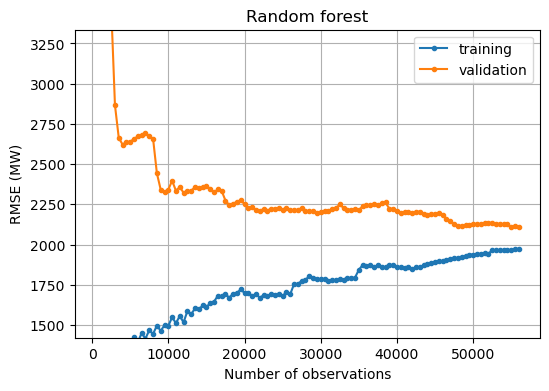

In [39]:
plot_learning_curves(rf_steps, rf_train_mse, rf_val_mse, title="Random forest")

In [40]:
xgb_steps, xgb_train_mse, xgb_val_mse = compute_learning_curves(
    xgb_model, X_train_prep, y_train, 500, verbose=True
)

Iteration 1/112: train_rmse=0.01, val_rmse=6091.19
Iteration 2/112: train_rmse=0.01, val_rmse=5834.49
Iteration 3/112: train_rmse=0.01, val_rmse=5081.80
Iteration 4/112: train_rmse=0.01, val_rmse=4822.96
Iteration 5/112: train_rmse=0.01, val_rmse=3675.62
Iteration 6/112: train_rmse=0.04, val_rmse=2667.91
Iteration 7/112: train_rmse=0.13, val_rmse=2752.00
Iteration 8/112: train_rmse=0.36, val_rmse=2627.63
Iteration 9/112: train_rmse=0.75, val_rmse=2583.16
Iteration 10/112: train_rmse=1.30, val_rmse=2431.66
Iteration 11/112: train_rmse=2.20, val_rmse=2494.52
Iteration 12/112: train_rmse=3.38, val_rmse=2468.74
Iteration 13/112: train_rmse=4.27, val_rmse=2399.28
Iteration 14/112: train_rmse=5.45, val_rmse=2468.42
Iteration 15/112: train_rmse=7.02, val_rmse=2414.59
Iteration 16/112: train_rmse=8.44, val_rmse=2406.09
Iteration 17/112: train_rmse=10.68, val_rmse=2246.62
Iteration 18/112: train_rmse=13.47, val_rmse=2194.51
Iteration 19/112: train_rmse=16.31, val_rmse=2162.82
Iteration 20/112: 

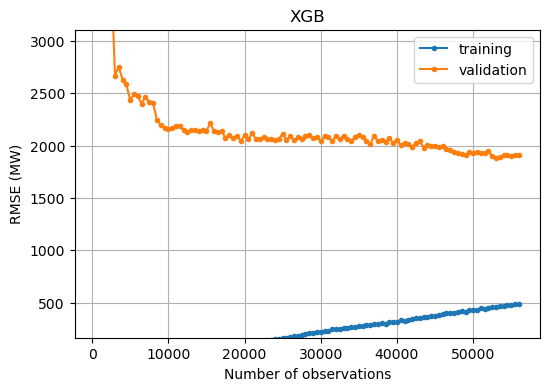

In [41]:
plot_learning_curves(xgb_steps, xgb_train_mse, xgb_val_mse, title="XGB")

# Feature Importance

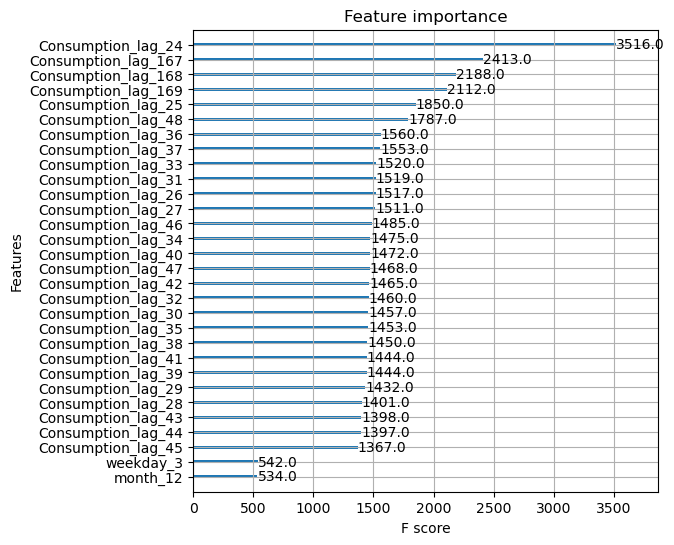

In [21]:
xgb_model.fit(X_train_prep, y=y_train)
_, ax = plt.subplots(1, 1, figsize=(6, 6))
_ = plot_importance(xgb_model, ax=ax, max_num_features=30)
plt.savefig('Feature_importance.png', bbox_inches="tight")

# Hyper parameter tuning

In [22]:
def xgb_grid_search_cv(
    params_grid, X, y, nfold,
    num_boost_round=1000, early_stopping_rounds=10,
):
    params_grid = ParameterGrid(params_grid)
    search_results = []
    print(f"Grid search CV : nfold={nfold}, " +
          f"numb_boost_round={num_boost_round}, " +
          f"early_stopping_round={early_stopping_rounds}")
    for params in params_grid:
        print(f"\t{params}")
        cv_df = xgb_cv(
            params=params, dtrain=DMatrix(X, y), nfold=nfold,
            num_boost_round=num_boost_round,
            early_stopping_rounds=early_stopping_rounds,
            shuffle=False, metrics={"rmse"},
        )
        cv_results = params.copy()
        cv_results["train-rmse-mean"] = cv_df["train-rmse-mean"].min()
        cv_results["test-rmse-mean"] = cv_df["test-rmse-mean"].min()
        search_results.append(cv_results)
    return pd.DataFrame(search_results)
    

In [23]:
params_grid = dict(
    eta = [0.05, 0.1, 0.3],
    max_depth = [2, 4, 6],
    min_child_weight = [5, 1]
)
xgb_search_scores = xgb_grid_search_cv(
    params_grid, X_train_prep, y_train, nfold=4, early_stopping_rounds=10
)

Grid search CV : nfold=4, numb_boost_round=1000, early_stopping_round=10
	{'eta': 0.05, 'max_depth': 2, 'min_child_weight': 5}
	{'eta': 0.05, 'max_depth': 2, 'min_child_weight': 1}
	{'eta': 0.05, 'max_depth': 4, 'min_child_weight': 5}
	{'eta': 0.05, 'max_depth': 4, 'min_child_weight': 1}
	{'eta': 0.05, 'max_depth': 6, 'min_child_weight': 5}
	{'eta': 0.05, 'max_depth': 6, 'min_child_weight': 1}
	{'eta': 0.1, 'max_depth': 2, 'min_child_weight': 5}
	{'eta': 0.1, 'max_depth': 2, 'min_child_weight': 1}
	{'eta': 0.1, 'max_depth': 4, 'min_child_weight': 5}
	{'eta': 0.1, 'max_depth': 4, 'min_child_weight': 1}
	{'eta': 0.1, 'max_depth': 6, 'min_child_weight': 5}
	{'eta': 0.1, 'max_depth': 6, 'min_child_weight': 1}
	{'eta': 0.3, 'max_depth': 2, 'min_child_weight': 5}
	{'eta': 0.3, 'max_depth': 2, 'min_child_weight': 1}
	{'eta': 0.3, 'max_depth': 4, 'min_child_weight': 5}
	{'eta': 0.3, 'max_depth': 4, 'min_child_weight': 1}
	{'eta': 0.3, 'max_depth': 6, 'min_child_weight': 5}
	{'eta': 0.3, 'max_d

In [24]:
xgb_search_scores.sort_values(by="test-rmse-mean")

,eta,max_depth,min_child_weight,train-rmse-mean,test-rmse-mean
5,0.05,6,1,1205.898883,1674.663007
4,0.05,6,5,1236.365815,1678.785555
11,0.10,6,1,1244.205042,1686.009423
10,0.10,6,5,1217.317060,1686.327829
9,0.10,4,1,1358.002592,1696.613667
8,0.10,4,5,1336.193649,1697.492964
2,0.05,4,5,1457.846854,1713.771609
3,0.05,4,1,1454.818810,1714.886366
14,0.30,4,5,1322.355452,1743.982611
15,0.30,4,1,1354.825788,1745.268889


# Training final model

In [25]:
final_model = XGBRegressor(
    n_estimators=1000, learning_rate=0.05, max_depth=6, min_child_weight=5
)
final_model.fit(
    X_train_prep, y_train, early_stopping_rounds=10,
    eval_set=[(X_train_prep, y_train), (X_test_prep, y_test)],
    verbose=False,
)

X:\Eigene Dateien\Jupyter\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [26]:
final_model.best_score

1823.3916393063485

# Predictions on test set

In [27]:
def compute_predictions_df(model, X, y):
    y_pred = model.predict(X)
    df = pd.DataFrame(dict(actual=y, prediction=y_pred), index=X.index)
    df["squared_error"] =  (df["actual"] - df["prediction"])**2
    return df

pred_df = compute_predictions_df(
    final_model, X_test_prep, y_test
)
pred_df.head()

,actual,prediction,squared_error
time,,,
2023-01-08 01:00:00+00:00,40024.50,38922.406250,1.214611e+06
2023-01-08 02:00:00+00:00,40110.50,38293.203125,3.302568e+06
2023-01-08 03:00:00+00:00,40193.00,38673.265625,2.309593e+06
2023-01-08 04:00:00+00:00,40074.00,41211.867188,1.294742e+06
2023-01-08 05:00:00+00:00,39986.75,42033.390625,4.188738e+06


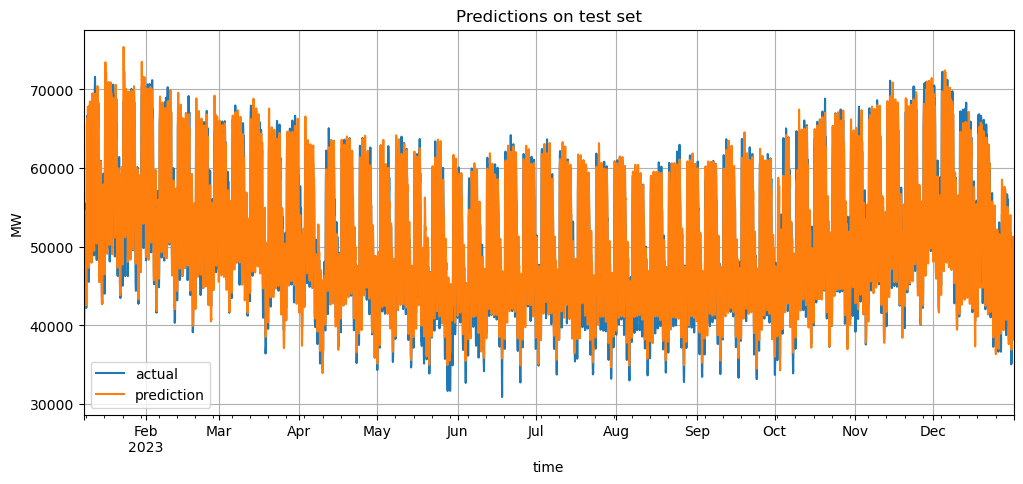

In [28]:
def plot_predictions(pred_df, start=None, end=None):
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    start = start or pred_df.index.min()
    end = end or pred_df.index.max()
    pred_df.loc[
        (pred_df.index >= start) & (pred_df.index <= end),
        ["actual", "prediction"]
    ].plot.line(ax=ax)
    ax.set_title("Predictions on test set")
    ax.set_ylabel("MW")
    ax.grid()
    fig.savefig('Test_predictions.png', bbox_inches="tight")

plot_predictions(pred_df)

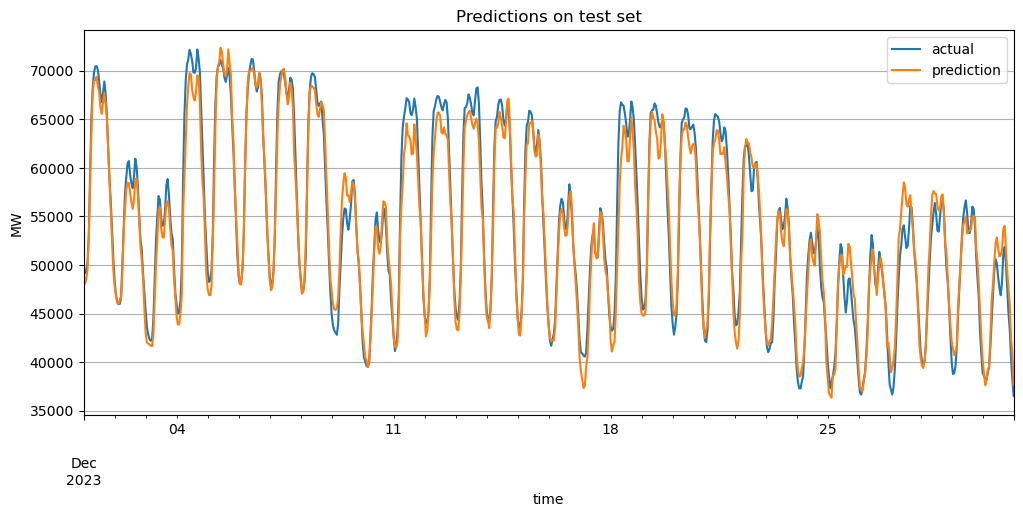

In [29]:
plot_predictions(pred_df,
                 start=pd.Timestamp("2023-12-01", tz="utc"),
                 end=pd.Timestamp("2023-12-31", tz="utc"))

# worst prediction days

In [30]:
daily_pred_df = pred_df.groupby(pd.Grouper(freq="D")).mean()
daily_pred_df.sort_values(by="squared_error", ascending=False).head(5)

,actual,prediction,squared_error
time,,,
2023-11-01 00:00:00+00:00,49408.979167,56276.792969,6.266924e+07
2023-06-08 00:00:00+00:00,44509.250000,51690.953125,5.802903e+07
2023-06-05 00:00:00+00:00,50195.489583,48698.964844,2.111589e+07
2023-05-29 00:00:00+00:00,38752.031250,42428.882812,2.012877e+07
2023-10-09 00:00:00+00:00,54033.312500,50988.699219,1.895404e+07


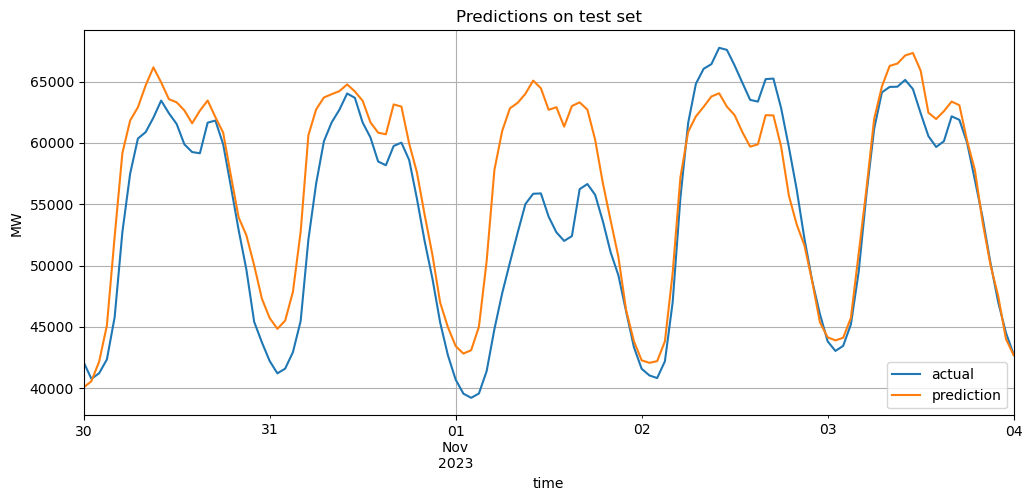

In [31]:
plot_predictions(pred_df,
                 start=pd.Timestamp("2023-10-30", tz="utc"),
                 end=pd.Timestamp("2023-11-04", tz="utc"))